<a href="https://colab.research.google.com/github/syedahamedchy/models/blob/master/Non_Scaled_Beam_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Relevant Libraries

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt
from functools import partial
from jax.experimental import stax
from jax.experimental import optimizers
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from jax.lib import xla_bridge
from google.colab import drive, files

Get Training and Test Data

In [4]:
drive.mount('/content/drive')

# Get training dataset:
with open('/content/drive/My Drive/Colab Notebooks/FYP/Data/Cam2_sinus_6.8Hz_1000mV/x_smoothed.csv', newline='') as csvfile:
  df = pd.read_csv(csvfile, delimiter=',')

L = (300/2210) #Pixel to mm scaling

raw = np.array(df['19'])
x_train = (raw - raw.mean(axis=0))*L
t_train = np.arange(len(x_train), dtype=np.float32) 
xdot_train = np.gradient(x_train)
xdotdot_train = np.gradient(xdot_train)

with open('/content/drive/My Drive/Colab Notebooks/FYP/Data/Cam2_sinus_6.8Hz_1000mV/y_smoothed.csv', newline='') as csvfile:
  df = pd.read_csv(csvfile, delimiter=',')

raw = np.array(df['19'])
y_train = (raw - raw.mean(axis=0))*L
ydot_train = np.gradient(y_train)
ydotdot_train = np.gradient(ydot_train)

x_train = np.stack((x_train, y_train, xdot_train, ydot_train), axis=1)
xt_train = np.stack((xdot_train, ydot_train, xdotdot_train, ydotdot_train), axis=1)

# Get testing dataset:
with open('/content/drive/My Drive/Colab Notebooks/FYP/Data/Cam2_sinus_6.8Hz_400mV/x_smoothed.csv', newline='') as csvfile:
  df = pd.read_csv(csvfile, delimiter=',')

raw = np.array(df['19'])
x_test = (raw - raw.mean(axis=0))*L
t_test = np.arange(len(x_test), dtype=np.float32) 
xdot_test = np.gradient(x_test)
xdotdot_test = np.gradient(xdot_test)

with open('/content/drive/My Drive/Colab Notebooks/FYP/Data/Cam2_sinus_6.8Hz_400mV/y_smoothed.csv', newline='') as csvfile:
  df = pd.read_csv(csvfile, delimiter=',')

raw = np.array(df['19'])
y_test = (raw - raw.mean(axis=0))*L
ydot_test = np.gradient(y_test)
ydotdot_test = np.gradient(ydot_test)

x_test = np.stack((x_test, y_test, xdot_test, ydot_test), axis=1)
xt_test = np.stack((xdot_test, ydot_test, xdotdot_test, ydotdot_test), axis=1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


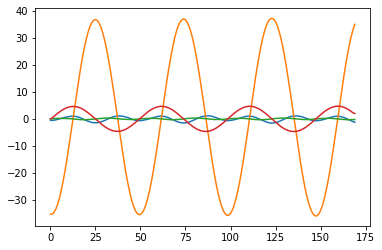

In [8]:
plt.plot(t_train, x_train)

Define Relevant Functions

In [3]:
def equation_of_motion(lagrangian, state, t=None):
  q, q_t = jnp.split(state, 2)
  q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
          @ (jax.grad(lagrangian, 0)(q, q_t)
             - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
  return jnp.concatenate([q_t, q_tt])

# Use the odeint to solve the Lagrangian modelled system.
def solve_lagrangian(lagrangian, initial_state, **kwargs):
  @partial(jax.jit, backend='gpu')
  def f(initial_state):
    return odeint(partial(equation_of_motion, lagrangian),
                  initial_state, **kwargs)
  return f(initial_state)

# Ensure that all inputs are normalised to only vary between -1 and 1. 
def normalise(state):
  return jnp.concatenate([state[:2], state[2:]])

# def normalise(state):
#   return jnp.concatenate([(state[:2] + 1) % (2) - 1, state[2:]])

# Define 4th order Runge-Kutta method for integration of losses. 
def rk4_step(f, x, t, h):
  k1 = h * f(x, t)
  k2 = h * f(x + k1/2, t + h/2)
  k3 = h * f(x + k2/2, t + h/2)
  k4 = h * f(x + k3, t + h)
  return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

Initialise Neural Network

In [4]:
def learned_lagrangian(params):
  def lagrangian(q, q_t):
    assert q.shape == (2,)
    state = normalise(jnp.concatenate([q, q_t]))
    return jnp.squeeze(nn_forward_fn(params, state), axis=-1)
  return lagrangian

# Now we define the loss function of the model. In our case it is the Mean 
# Squared Error between the predicted and the observed accelerations. 
@jax.jit
def loss(params, batch, time_step=None):
  state, targets = batch
  if time_step is not None:
    f = partial(equation_of_motion, learned_lagrangian(params))
    preds = jax.vmap(partial(rk4_step, f, t=0.0, h=time_step))(state)
  else:
    preds = jax.vmap(partial(equation_of_motion, learned_lagrangian(params)))(state)
  return jnp.mean((preds - targets) ** 2)

# Set up the Neural Network. 
init_random_params, nn_forward_fn = stax.serial(
    stax.Dense(64),
    stax.Softplus,
    stax.Dense(64),
    stax.Softplus,
    stax.Dense(1),
)

@jax.jit
def update_derivative(i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, jax.grad(loss)(params, batch, None), opt_state)

Train the Neural Network

In [5]:
# Initialise the parametes in the neural network to be random. 
rng = jax.random.PRNGKey(0)
_, init_params = init_random_params(rng, (-1, 4))

# Define the training process. 
batch_size = 100
test_every = 10
num_batches = 500 # Further training seems to overfit the model. 
# Change no. batches to 2500 and batch size to 10 if you are training with multiple experimental datasets. 

train_losses = []
test_losses = []

# Define the training optimiser.
opt_init, opt_update, get_params = optimizers.adam(
    lambda t: jnp.select([t < batch_size*(num_batches//3),
                          t < batch_size*(2*num_batches//3),
                          t > batch_size*(2*num_batches//3)],
                         [1e-3, 3e-4, 1e-4]))
opt_state = opt_init(init_params)

# Perform training process. 
for iteration in range(batch_size*num_batches + 1):
  if iteration % batch_size == 0:
    params = get_params(opt_state)
    train_loss = loss(params, (x_train, xt_train))
    train_losses.append(train_loss)
    test_loss = loss(params, (x_test, xt_test))
    test_losses.append(test_loss)
    if iteration % (batch_size*test_every) == 0:
      print(f"iteration={iteration}, train_loss={train_loss:.6f}, test_loss={test_loss:.6f}")
  opt_state = update_derivative(iteration, opt_state, (x_train, xt_train))

params = get_params(opt_state)

iteration=0, train_loss=237.869812, test_loss=47.611095
iteration=1000, train_loss=0.009333, test_loss=0.033174
iteration=2000, train_loss=0.001545, test_loss=0.029582
iteration=3000, train_loss=0.000911, test_loss=0.029942
iteration=4000, train_loss=0.000622, test_loss=0.030268
iteration=5000, train_loss=0.000479, test_loss=0.030851
iteration=6000, train_loss=0.000412, test_loss=0.031331
iteration=7000, train_loss=0.000381, test_loss=0.031183
iteration=8000, train_loss=0.000362, test_loss=0.029987
iteration=9000, train_loss=0.000351, test_loss=0.028058
iteration=10000, train_loss=0.000337, test_loss=0.025558
iteration=11000, train_loss=0.002418, test_loss=0.018068
iteration=12000, train_loss=0.000316, test_loss=0.019107
iteration=13000, train_loss=0.000381, test_loss=0.015717
iteration=14000, train_loss=0.000305, test_loss=0.012989
iteration=15000, train_loss=0.000298, test_loss=0.011219
iteration=16000, train_loss=0.000452, test_loss=0.010433
iteration=17000, train_loss=0.000289, tes

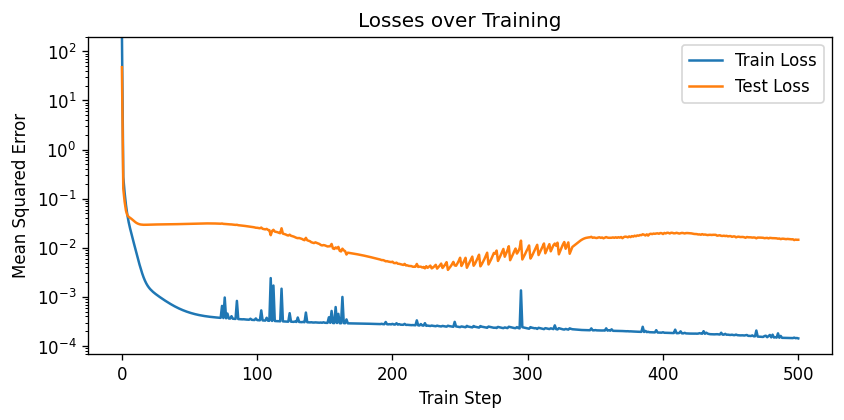

In [6]:
plt.figure(figsize=(8, 3.5), dpi=120)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.yscale('log')
plt.ylim(None, 200)
plt.title('Losses over Training')
plt.xlabel("Train Step")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()

Make Predictions Using Trained Model

In [ ]:
# Compare to training dataset.
experimental = x_train
N = len(x_train[:, 0])
time = np.linspace(0, N, N)
X0 = x_train[0, :]
# %time predicted = jax.device_get(solve_lagrangian(learned_lagrangian(params), X0, t=time))
model = solve_lagrangian(learned_lagrangian(params), X0, t=time)
time = time*0.003

# # De-normalise the data and scale it to real-life. 
# L = 300/2210
# experimental[:, 0] = (experimental[:, 0] * x_train_std * L) #+ x_train_mean
# experimental[:, 1] = (experimental[:, 1] * y_train_std * L) #+ y_train_mean
# model = np.empty_like(predicted)
# model[:, 0] = (predicted[:, 0] * x_train_std * L ) #+ x_train_mean
# model[:, 1] = (predicted[:, 1] * y_train_std * L ) #+ y_train_mean

# Plot them alongside. 
figure, axis = plt.subplots(2, 1, figsize=(10,15))

axis[0].set_title("Experimental vs LNN: Y-Displacement (Training Data)", fontsize=16)
axis[0].plot(time, experimental[:, 1], 'g-', label=r'Exact Displacement')
axis[0].plot(time, model[:, 1], 'r--', label=r'LNN Predicted Displacement')
axis[0].set_xlabel("Time (s)", fontsize=16)
axis[0].set_ylabel("Displacement (mm)", fontsize=16)
axis[0].legend(fontsize=14, loc='lower right')
plt.rc('xtick', labelsize='LARGE')

axis[1].set_title("Experimental vs LNN: X-Displacement (Training Data)", fontsize=16)
axis[1].plot(time, experimental[:, 0], 'g-', label=r'Exact Displacement')
axis[1].plot(time, model[:, 0], 'r--', label=r'LNN Predicted Displacement')
axis[1].set_xlabel("Time (s)", fontsize=16)
axis[1].set_ylabel("Displacement (mm)", fontsize=16)
axis[1].legend(fontsize=14, loc='lower right')
plt.rc('xtick', labelsize='LARGE')

In [ ]:
# Compare to testing dataset. 
experimental = x_test
N = len(x_test[:, 0])
time = np.linspace(0, N, N)
X0 = x_test[0, :]
model = solve_lagrangian(learned_lagrangian(params), X0, t=time)
time = time*0.003

# # De-normalise the data and scale it to real-life. 
# L = 300/2210
# experimental[:, 0] = (experimental[:, 0] * x_test_std * L) #+ x_train_mean
# experimental[:, 1] = (experimental[:, 1] * y_test_std * L) #+ y_train_mean
# model = np.empty_like(predicted)
# model[:, 0] = (predicted[:, 0] * x_test_std * L ) #+ x_train_mean
# model[:, 1] = (predicted[:, 1] * y_test_std * L ) #+ y_train_mean

# Plot them alongside. 
figure, axis = plt.subplots(2, 1, figsize=(10,15))

axis[0].set_title("Experimental vs LNN: Y-Displacement (Testing Data)", fontsize=16)
axis[0].plot(time, experimental[:, 1], 'g-', label=r'Exact Displacement')
axis[0].plot(time, model[:, 1], 'r--', label=r'LNN Predicted Displacement')
axis[0].set_xlabel("Time (s)", fontsize=16)
axis[0].set_ylabel("Displacement (mm)", fontsize=16)
axis[0].legend(fontsize=14, loc='lower right')
plt.rc('xtick', labelsize='LARGE')

axis[1].set_title("Experimental vs LNN: X-Displacement (Testing Data)", fontsize=16)
axis[1].plot(time, experimental[:, 0], 'g-', label=r'Exact Displacement')
axis[1].plot(time, model[:, 0], 'r--', label=r'LNN Predicted Displacement')
axis[1].set_xlabel("Time (s)", fontsize=16)
axis[1].set_ylabel("Displacement (mm)", fontsize=16)
axis[1].legend(fontsize=14, loc='lower right')
plt.rc('xtick', labelsize='LARGE')

In [ ]:
# Make predictions with testing dataset beyond the experimentally observed time period. 
experimental = x_test
N = len(x_test[:, 0])
time = np.linspace(0, 4*N, 2*N)
X0 = x_test[0, :]
predicted = solve_lagrangian(learned_lagrangian(params), X0, t=time)
time = time*0.003

# De-normalise the data and scale it to real-life. 
L = 300/2210
experimental[:, 0] = (experimental[:, 0] * x_test_std * L) 
experimental[:, 1] = (experimental[:, 1] * y_test_std * L) 
model = np.empty_like(predicted)
model[:, 0] = (predicted[:, 0] * x_test_std * L ) 
model[:, 1] = (predicted[:, 1] * y_test_std * L ) 

# Plot them alongside. 
figure, axis = plt.subplots(2, 1, figsize=(25,15))

axis[0].set_title("Experimental vs LNN: Y-Displacement (Testing Data Extended)", fontsize=16)
axis[0].plot(time[0:N], experimental[:, 1], 'g-', label=r'Exact Displacement')
axis[0].plot(time, model[:, 1], 'r--', label=r'LNN Predicted Displacement')
axis[0].set_xlabel("Time (s)", fontsize=16)
axis[0].set_ylabel("Displacement (mm)", fontsize=16)
axis[0].legend(fontsize=14, loc='lower right')
plt.rc('xtick', labelsize='LARGE')

axis[1].set_title("Experimental vs LNN: X-Displacement (Testing Data Extended)", fontsize=16)
axis[1].plot(time[0:N], experimental[:, 0], 'g-', label=r'Exact Displacement')
axis[1].plot(time, model[:, 0], 'r--', label=r'LNN Predicted Displacement')
axis[1].set_xlabel("Time (s)", fontsize=16)
axis[1].set_ylabel("Displacement (mm)", fontsize=16)
axis[1].legend(fontsize=14, loc='lower right')
plt.rc('xtick', labelsize='LARGE')